<a href="https://colab.research.google.com/github/ramayer/google-colab-examples/blob/main/HelloWorld_Transformer_with_RoPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HelloWorld Transformer with RoPE -- demonstrate RoPE benefits

The simplest possible transformer with RoPE

* Predict the next sample of `f(t) = sin(t) + ξ` using RoPE and without positional embedding.
* Shows how RoPE helps training converge much faster
* Visualizes the attention weights to show that RoPE helps it attend to more interesting/important parts of previous tokens.


In [1]:
%pip install --quiet einx torchview

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 4.5 MB/s eta 0:00:00


Using device: cpu

Training Model WITHOUT positional embedding...
Epoch 1/15, Loss: 0.035371
Epoch 2/15, Loss: 0.006577
Epoch 3/15, Loss: 0.006168
Epoch 4/15, Loss: 0.005905
Epoch 5/15, Loss: 0.005698
Epoch 6/15, Loss: 0.005519
Epoch 7/15, Loss: 0.005432
Epoch 8/15, Loss: 0.005334
Epoch 9/15, Loss: 0.005348
Epoch 10/15, Loss: 0.005365
Epoch 11/15, Loss: 0.005211
Epoch 12/15, Loss: 0.005149
Epoch 13/15, Loss: 0.005026
Epoch 14/15, Loss: 0.005118
Epoch 15/15, Loss: 0.005006

Training Model WITH RoPE positional embedding...
Epoch 1/15, Loss: 0.034696
Epoch 2/15, Loss: 0.005665
Epoch 3/15, Loss: 0.005460
Epoch 4/15, Loss: 0.005325
Epoch 5/15, Loss: 0.005218
Epoch 6/15, Loss: 0.005125
Epoch 7/15, Loss: 0.005049
Epoch 8/15, Loss: 0.004820
Epoch 9/15, Loss: 0.004611
Epoch 10/15, Loss: 0.004267
Epoch 11/15, Loss: 0.004091
Epoch 12/15, Loss: 0.004000
Epoch 13/15, Loss: 0.003915
Epoch 14/15, Loss: 0.003917
Epoch 15/15, Loss: 0.003883

Generating prediction snapshots...
NP
Epoch 1/2, Loss: 0.0562

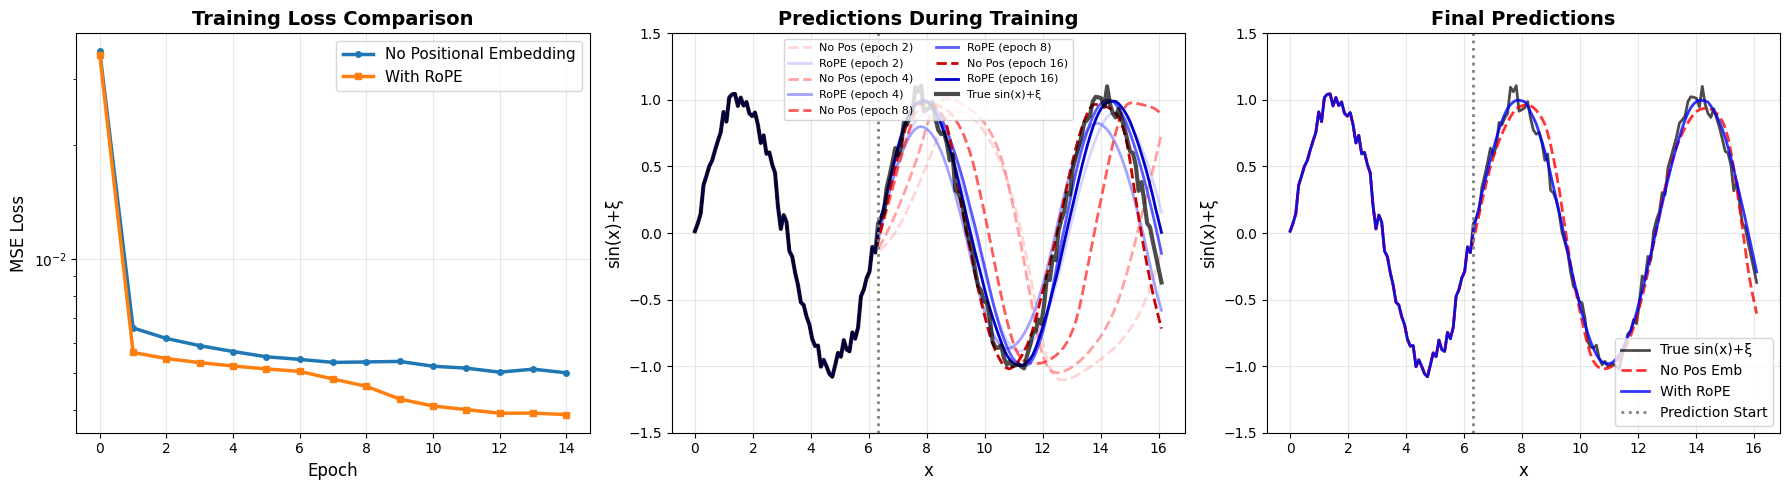


TRAINING COMPLETE!


In [2]:
"""
Minimal Transformer Demo: Predicting sin(x) with and without RoPE
Demonstrates transformer internals and why positional information matters.
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import einx

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# =============================================================================
# 1. ROTARY POSITION EMBEDDING (RoPE) IMPLEMENTATION
# =============================================================================

def precompute_freqs_cis(dim: int, seq_len: int, theta: float = 10000.0):
    """Precompute RoPE rotation frequencies."""
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(seq_len, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # (seq_len, dim//2)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # e^(i*theta)
    return freqs_cis


def apply_rotary_emb(x, freqs_cis):
    """Apply rotary position embedding to a single tensor (Q or K)."""
    # Reshape to complex: (b, s, h, d) -> (b, s, h, d//2)
    x_complex = einx.rearrange("b s h (d c) -> b s h d c", x, c=2)
    x_complex = torch.view_as_complex(x_complex.float())

    # Broadcast freqs_cis and rotate
    freqs_cis = einx.rearrange("s d -> 1 s 1 d", freqs_cis[:x_complex.shape[1], :])
    x_rotated = x_complex * freqs_cis

    # Back to real: (b, s, h, d//2) -> (b, s, h, d)
    x_out = torch.view_as_real(x_rotated)
    x_out = einx.rearrange("b s h d c -> b s h (d c)", x_out)
    return x_out.type_as(x)


# =============================================================================
# 2. TRANSFORMER BUILDING BLOCKS
# =============================================================================

class MultiHeadAttention(nn.Module):
    """Multi-head self-attention with optional RoPE."""

    def __init__(self, d_model, n_heads, use_rope=False):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.use_rope = use_rope

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x, freqs_cis=None, return_attention=False):
        b, s = x.shape[0], x.shape[1]

        # Project and reshape: (b, s, d) -> (b, s, h, d_head)
        Q = einx.rearrange("b s (h d) -> b s h d", self.q_proj(x), h=self.n_heads)
        K = einx.rearrange("b s (h d) -> b s h d", self.k_proj(x), h=self.n_heads)
        V = einx.rearrange("b s (h d) -> b s h d", self.v_proj(x), h=self.n_heads)

        # Apply RoPE if enabled (to Q and K independently)
        if self.use_rope and freqs_cis is not None:
            Q = apply_rotary_emb(Q, freqs_cis)
            K = apply_rotary_emb(K, freqs_cis)

        # Attention: (b, h, s, d_head)
        Q, K, V = [einx.rearrange("b s h d -> b h s d", t) for t in [Q, K, V]]

        scores = torch.matmul(Q, einx.rearrange("b h s d -> b h d s", K)) / np.sqrt(self.head_dim)

        # Apply causal mask (prevent attending to future positions)
        causal_mask = torch.triu(torch.ones(s, s, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(causal_mask, float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)

        # Merge heads: (b, h, s, d_head) -> (b, s, d)
        attn_output = einx.rearrange("b h s d -> b s (h d)", attn_output)
        output = self.o_proj(attn_output)

        if return_attention:
            return output, attn_weights
        return output


class FeedForward(nn.Module):
    """Position-wise feed-forward network."""

    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))


class TransformerBlock(nn.Module):
    """Transformer block: attention + feed-forward with residuals."""

    def __init__(self, d_model, n_heads, d_ff, use_rope=False):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, use_rope)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, freqs_cis=None, return_attention=False):
        # Attention with residual
        if return_attention:
            attn_out, attn_weights = self.attention(
                self.norm1(x), freqs_cis, return_attention=True
            )
            x = x + attn_out
            x = x + self.feed_forward(self.norm2(x))
            return x, attn_weights
        else:
            x = x + self.attention(self.norm1(x), freqs_cis)
            x = x + self.feed_forward(self.norm2(x))
            return x


class SimpleTransformer(nn.Module):
    """Simple transformer for time series prediction."""

    def __init__(self, d_model=64, n_heads=4, n_layers=2, d_ff=256,
                 seq_len=32, use_rope=False):
        super().__init__()
        self.d_model = d_model
        self.use_rope = use_rope

        # Input embedding (from 1D value to d_model dimensions)
        self.input_embedding = nn.Linear(1, d_model)

        # Precompute RoPE frequencies if needed
        if use_rope:
            self.register_buffer(
                "freqs_cis",
                precompute_freqs_cis(d_model // n_heads, seq_len)
            )

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, use_rope)
            for _ in range(n_layers)
        ])

        # Output projection
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x, return_attention=False):
        # x shape: (batch, seq_len, 1)
        x = self.input_embedding(x)  # (batch, seq_len, d_model)

        freqs_cis = self.freqs_cis if self.use_rope else None

        if return_attention:
            # Only return attention from first block for visualization
            x, attn_weights = self.blocks[0](x, freqs_cis, return_attention=True)
            for block in self.blocks[1:]:
                x = block(x, freqs_cis)
            x = self.output_proj(x)
            return x, attn_weights
        else:
            for block in self.blocks:
                x = block(x, freqs_cis)
            x = self.output_proj(x)
            return x


# =============================================================================
# 3. DATA GENERATION
# =============================================================================

class SinusoidDataset(Dataset):
    """Generate sin(x) sequences for next-step prediction."""

    def __init__(self, n_samples=1000, seq_len=64, noise_level=0.05):
        self.n_samples = n_samples
        self.seq_len = seq_len
        self.noise_level = noise_level
        self.starts = np.random.uniform(0, 4 * np.pi, n_samples)
        self.freqs = np.random.uniform(0.8, 1.2, n_samples)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        start = self.starts[idx]
        freq = self.freqs[idx]
        x = np.linspace(start, start + 2*np.pi*freq, self.seq_len + 1)
        y = np.sin(x)

        if self.noise_level > 0:
            y = y + np.random.normal(0, self.noise_level, len(y))

        input_seq = torch.FloatTensor(y[:-1]).unsqueeze(-1)
        target_seq = torch.FloatTensor(y[1:]).unsqueeze(-1)

        return input_seq, target_seq


# =============================================================================
# 4. TRAINING FUNCTION
# =============================================================================

def train_model(model, train_loader, n_epochs=10, lr=0.001, device='cpu'):
    """Train the transformer model."""
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_input, batch_target in train_loader:
            batch_input = batch_input.to(device)
            batch_target = batch_target.to(device)

            optimizer.zero_grad()
            output = model(batch_input)
            loss = criterion(output, batch_target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 1 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}")

    return losses


# =============================================================================
# 5. TRAINING
# =============================================================================

# Hyperparameters
SEQ_LEN = 64
BATCH_SIZE = 32
N_EPOCHS = 15
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}\n")

# Create dataset with varying frequency sin waves
train_dataset = SinusoidDataset(n_samples=2000, seq_len=SEQ_LEN, noise_level=0.05)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create two models: one with RoPE, one without
print("="*60)
print("Training Model WITHOUT positional embedding...")
print("="*60)
torch.manual_seed(42)

model_no_pos = SimpleTransformer(
    d_model=64, n_heads=4, n_layers=2, d_ff=256,
    seq_len=SEQ_LEN, use_rope=False
)
losses_no_pos = train_model(model_no_pos, train_loader, n_epochs=N_EPOCHS, device=DEVICE)

print("\n" + "="*60)
print("Training Model WITH RoPE positional embedding...")
print("="*60)
torch.manual_seed(42)

model_with_rope = SimpleTransformer(
    d_model=64, n_heads=4, n_layers=2, d_ff=256,
    seq_len=SEQ_LEN, use_rope=True
)
losses_with_rope = train_model(model_with_rope, train_loader, n_epochs=N_EPOCHS, device=DEVICE)


# =============================================================================
# 6. VISUALIZATION
# =============================================================================

fig = plt.figure(figsize=(18, 5))

# Plot 1: Training curves
ax1 = plt.subplot(1, 3, 1)
plt.plot(losses_no_pos, label='No Positional Embedding', linewidth=2.5, marker='o', markersize=4)
plt.plot(losses_with_rope, label='With RoPE', linewidth=2.5, marker='s', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 2: Snapshot predictions at different epochs
ax2 = plt.subplot(1, 3, 2)

# Re-train and save snapshots
print("\nGenerating prediction snapshots...")
model_no_pos_snap = SimpleTransformer(d_model=64, n_heads=4, n_layers=2, d_ff=256,
                                       seq_len=SEQ_LEN, use_rope=False).to(DEVICE)
model_rope_snap = SimpleTransformer(d_model=64, n_heads=4, n_layers=2, d_ff=256,
                                     seq_len=SEQ_LEN, use_rope=True).to(DEVICE)

# Create test data with noise matching training distribution
n_test_points = SEQ_LEN + 100
test_x = np.linspace(0, 2*np.pi * (n_test_points / SEQ_LEN), n_test_points)
test_y_clean = np.sin(test_x)
test_y = test_y_clean + np.random.normal(0, 0.05, len(test_x))  # Add noise like training
test_context = torch.FloatTensor(test_y[:SEQ_LEN]).unsqueeze(0).unsqueeze(-1).to(DEVICE)

snapshot_epochs = [2, 4, 8, 16]
colors_no_pos = ['#ff9999', '#ff6666', '#ff3333', '#cc0000']
colors_rope = ['#9999ff', '#6666ff', '#3333ff', '#0000cc']

for epoch_idx, target_epoch in enumerate(snapshot_epochs):
    # Train to target epoch
    if epoch_idx == 0:
        epochs_to_train = target_epoch
    else:
        epochs_to_train = target_epoch - snapshot_epochs[epoch_idx - 1]

    if epochs_to_train > 0:
        print("NP")
        torch.manual_seed(42 + target_epoch)
        train_model(model_no_pos_snap, train_loader, n_epochs=epochs_to_train, device=DEVICE)
        print("RP")
        torch.manual_seed(42 + target_epoch)

        train_model(model_rope_snap, train_loader, n_epochs=epochs_to_train, device=DEVICE)

    # Generate predictions
    model_no_pos_snap.eval()
    model_rope_snap.eval()

    with torch.no_grad():
        context_no_pos = test_context.clone()
        context_rope = test_context.clone()
        preds_no_pos = test_y[:SEQ_LEN].tolist()
        preds_rope = test_y[:SEQ_LEN].tolist()

        for i in range(100):  # Predict much further
            pred_no_pos = model_no_pos_snap(context_no_pos)[:, -1:, :]
            pred_rope = model_rope_snap(context_rope)[:, -1:, :]
            preds_no_pos.append(pred_no_pos.cpu().item())
            preds_rope.append(pred_rope.cpu().item())
            # Update each context with its OWN predictions
            context_no_pos = torch.cat([context_no_pos[:, 1:, :], pred_no_pos], dim=1)
            context_rope = torch.cat([context_rope[:, 1:, :], pred_rope], dim=1)

    alpha = 0.4 + (epoch_idx * 0.2)
    plt.plot(test_x[:SEQ_LEN+100], preds_no_pos, '--', color=colors_no_pos[epoch_idx],
             linewidth=2, alpha=alpha, label=f'No Pos (epoch {target_epoch})')
    plt.plot(test_x[:SEQ_LEN+100], preds_rope, '-', color=colors_rope[epoch_idx],
             linewidth=2, alpha=alpha, label=f'RoPE (epoch {target_epoch})')

plt.plot(test_x, test_y, 'k-', linewidth=3, alpha=0.7, label='True sin(x)+ξ')
plt.axvline(x=test_x[SEQ_LEN], color='gray', linestyle=':', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('sin(x)+ξ', fontsize=12)
plt.title('Predictions During Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.ylim(-1.5, 1.5)

# Plot 3: Final comparison
ax3 = plt.subplot(1, 3, 3)

##
#model_no_pos = model_no_pos_snap
#model_with_rope = model_rope_snap

model_no_pos.eval()
model_with_rope.eval()

with torch.no_grad():
    context_no_pos = test_context.clone()
    context_rope = test_context.clone()
    predictions_no_pos = test_y[:SEQ_LEN].tolist()
    predictions_rope = test_y[:SEQ_LEN].tolist()

    for i in range(100):  # Predict much further
        pred_no_pos = model_no_pos(context_no_pos)[:, -1:, :]
        pred_rope = model_with_rope(context_rope)[:, -1:, :]
        predictions_no_pos.append(pred_no_pos.cpu().item())
        predictions_rope.append(pred_rope.cpu().item())
        # Update each context with its OWN predictions
        context_no_pos = torch.cat([context_no_pos[:, 1:, :], pred_no_pos], dim=1)
        context_rope = torch.cat([context_rope[:, 1:, :], pred_rope], dim=1)

plt.plot(test_x, test_y, 'k-', label='True sin(x)+ξ', linewidth=2, alpha=0.7)
plt.plot(test_x[:SEQ_LEN+100], predictions_no_pos, 'r--',
         label='No Pos Emb', linewidth=2, alpha=0.8)
plt.plot(test_x[:SEQ_LEN+100], predictions_rope, 'b-',
         label='With RoPE', linewidth=2, alpha=0.8)
plt.axvline(x=test_x[SEQ_LEN], color='gray', linestyle=':', linewidth=2, label='Prediction Start')
plt.xlabel('x', fontsize=12)
plt.ylabel('sin(x)+ξ', fontsize=12)
plt.title('Final Predictions', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)

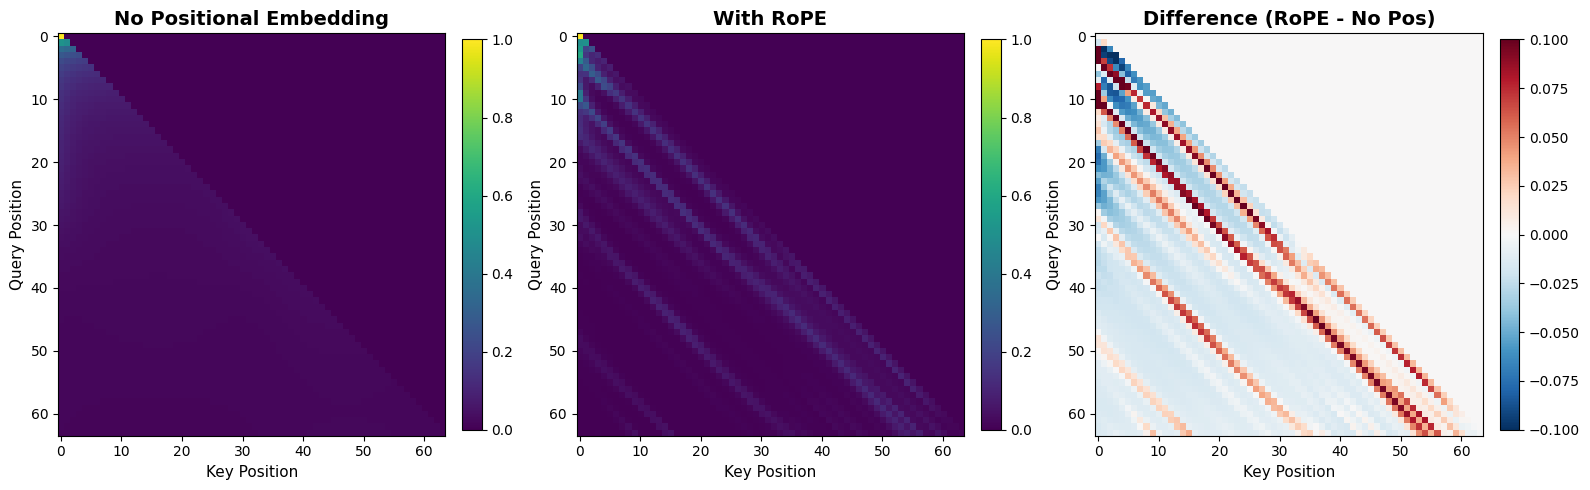


Key Observations:
• Without pos embedding: attention is nearly uniform/position-invariant
• With RoPE: attention has diagonal structure (nearby positions matter more)
• Difference map: shows RoPE creates position-dependent attention patterns


In [3]:
# =============================================================================
# ATTENTION PATTERN VISUALIZATION
# =============================================================================

"""
Visualize attention patterns to see how RoPE affects what each position attends to.
Without positional info, attention patterns are position-invariant.
With RoPE, positions attend differently based on their location.
"""

model_no_pos.eval()
model_with_rope.eval()

# Generate a single test sequence
test_start = np.pi
test_x = np.linspace(test_start, test_start + 2*np.pi, SEQ_LEN)
test_y = np.sin(test_x)
test_input = torch.FloatTensor(test_y).unsqueeze(0).unsqueeze(-1).to(DEVICE)

# Extract attention weights from first layer
with torch.no_grad():
    _, attn_no_pos = model_no_pos(test_input, return_attention=True)
    _, attn_rope = model_with_rope(test_input, return_attention=True)

# Average across heads: (batch, n_heads, seq_len, seq_len) -> (seq_len, seq_len)
attn_no_pos = attn_no_pos[0].mean(dim=0).cpu().numpy()
attn_rope = attn_rope[0].mean(dim=0).cpu().numpy()

# Plot attention patterns
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# No positional embedding
im1 = axes[0].imshow(attn_no_pos, cmap='viridis', aspect='auto')
axes[0].set_title('No Positional Embedding', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Key Position', fontsize=11)
axes[0].set_ylabel('Query Position', fontsize=11)
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# With RoPE
im2 = axes[1].imshow(attn_rope, cmap='viridis', aspect='auto')
axes[1].set_title('With RoPE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Key Position', fontsize=11)
axes[1].set_ylabel('Query Position', fontsize=11)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Difference (shows diagonal structure from RoPE)
diff = attn_rope - attn_no_pos
im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-0.1, vmax=0.1)
axes[2].set_title('Difference (RoPE - No Pos)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Key Position', fontsize=11)
axes[2].set_ylabel('Query Position', fontsize=11)
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Without pos embedding: attention is nearly uniform/position-invariant")
print("• With RoPE: attention has diagonal structure (nearby positions matter more)")
print("• Difference map: shows RoPE creates position-dependent attention patterns")

## Visualize network

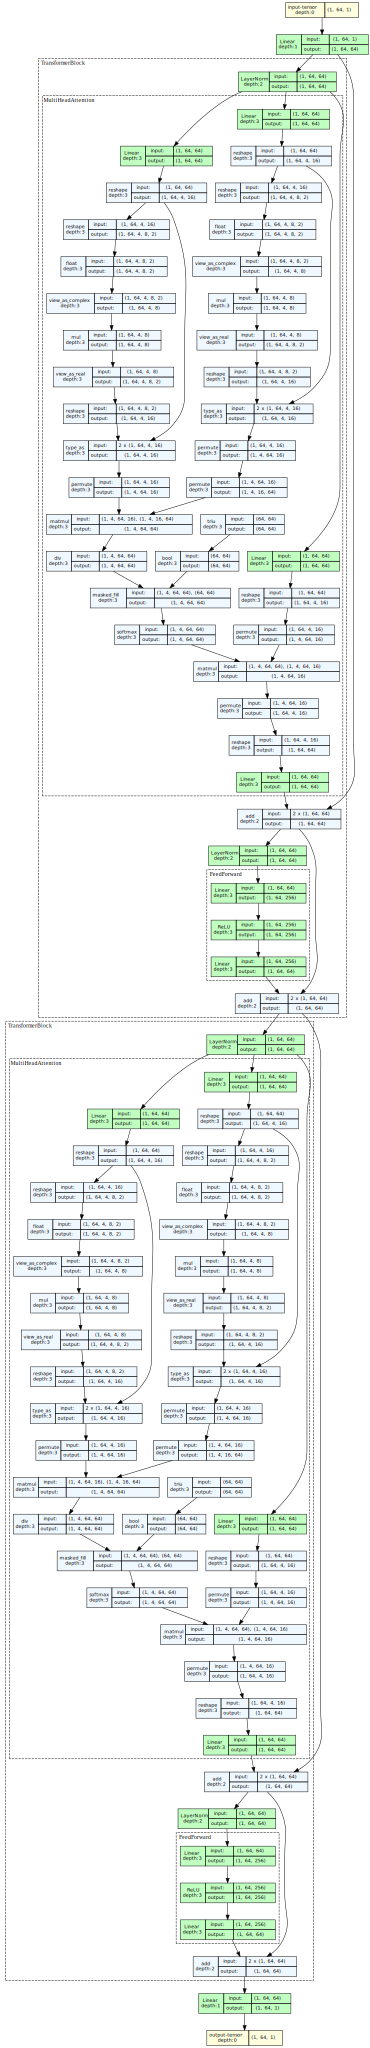

In [6]:
# =============================================================================
# NETWORK ARCHITECTURE VISUALIZATION
# =============================================================================

from torchview import draw_graph

# Create a sample input
sample_input = torch.randn(1, SEQ_LEN, 1).to(DEVICE)

# Visualize the RoPE model
model_graph = draw_graph(
    model_with_rope,
    input_data=sample_input,
    expand_nested=True,
    depth=3,  # Show 3 levels of nesting
    device=DEVICE
)

# Display the graph
model_graph.visual_graph